# Predicting Video Game Sales

## Notes for cleaning dataset
- 269 dates missing, often for Japanese Releases or Atari 2600 games
- 245 dates added, some games seem to have been cancelled for a platform although there are numbers for sales volume, so it's best to sort them out (by Year_Of_Release == None)
- Many games seem to have been released in Japan only => Should be ignored (JP_Sales == Global_Sales otherwise)
- Some games explicitly stated (jp sales/japan sales/etc.) => merged logically with global title, sometimes strong effect; influence of Japan Sales would be missing for some rows otherwise
- Slightly contradictory information for a few rows merged anyway using max(entry1, entry2)
- "tbd" => None
- Fun Fact: River Raid a top seller!

In [1]:
# TODO: use functions
# TODO: clean code
# TODO: visualizations
# TODO: check regressor characteristics

# Import libraries necessary for this project
import numpy as np
import pandas as pd
import scipy as sp
import time

import matplotlib.pyplot as plt

# Allows the use of display() for DataFrames
from IPython.display import display

# sklearn stuff
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.tools.plotting import scatter_matrix
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split, learning_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet, LassoLars, Ridge
from sklearn import svm

# make pretty
plt.style.use('ggplot')

# Pretty display for notebooks
%matplotlib inline

# Data Schema

## Dataset 1 (Video_Games_Sales_as_at_22_Dec_2016.csv)
This is my main dataset. It will be used to predict video game sales.

| title           | description                                                   | data type |
|-----------------|---------------------------------------------------------------|-----------|
| Name            | Name of the game                                              | String    |
| Platform        | Platform                                                      | String    |
| Year_of_Release | Year of release                                               | Numeric   |
| Genre           | Genre                                                         | String    |
| Publisher       | Publisher                                                     | String    |
| NA_Sales        | Game sales in North America (in millions of units)            | Numeric   |
| EU_Sales        | Game sales in the European Union (in millions of units)       | Numeric   |
| JP_Sales        | Game sales in Japan (in millions of units)                    | Numeric   |
| Other_Sales     | Game sales in the rest of the world (in millions of units)    | Numeric   |
| Global_Sales    | Total sales in the world (in millions of units)               | Numeric   |
| Critic_Score    | Aggregate score compiled by Metacritic staff                  | Numeric   |
| Critic_Count    | The number of critics used in coming up with the Critic_score | Numeric   |
| User_Score      | Score by Metacritic's subscribers                             | Numeric   |
| User_Count      | Number of users who gave the user_score                       | Numeric   |
| Developer       | Party responsible for creating the game                       | String    |
| Rating          | The [ESRB](https://www.esrb.org/) ratings                     | String    |

## Dataset 2 (ign.csv)
This is my secondary dataset. It might be used to support the primary dataset, but this would probably require major effort for merging both.

| title           | description                                                   | data type |
|-----------------|---------------------------------------------------------------|-----------|
| ID              | ID                                                            | Numeric   |
| score_phrase    | Game rating as a phrase                                       | String    |
| title           | Name of the game                                              | String    |
| url             | URL to source of data                                         | String    |
| platform        | Platform                                                      | String    |
| score           | Game rating as a float                                        | Numeric   |
| genre           | Genre                                                         | String    |
| editors_choice  | Special recommendation of the editor                          | String    |
| release_year    | Year of release                                               | Numeric   |
| release_month   | Month of release                                              | Numeric   |
| release_day     | Day of release                                                | Numeric   |


We can remove several colums in dataset2 that we don't need:
* **ID** which is just an ID that's not used in dataset 1
* **score_phrase**, because it redundant to _score_ and less precise
* **url**, because that's just the origin of the data
* **release_month**, too much detail
* **release_day**, too much detail
The next step will be to load the datasets.

In [2]:
def loadDatasets(cleaned = True):
    """Load all necessary datasets"""
    # Load dataset #1
    if (cleaned):
        try:
            dataset1 = pd.read_csv("data/Video_Games_Sales_as_at_22_Dec_2016_cleaned.csv")
            #display("Dataset #1 has {} samples with {} possible features.".format(*dataset1.shape))
        except:
            display("Dataset #1 could not be loaded. Is the dataset missing?")
    else:
        try:
            dataset1 = pd.read_csv("data/Video_Games_Sales_as_at_22_Dec_2016.csv")
            #display("Dataset #1 has {} samples with {} possible features.".format(*dataset1.shape))

            # tbd to NaN (needed for uncleaned dataset)
            clean_dataset1 = clean_dataset1.replace('tbd', float('NaN'))

            # correct data types (needed for uncleaned dataset)
            clean_dataset1['User_Score'] = clean_dataset1['User_Score'].apply(pd.to_numeric)            
        except:
            display("Dataset #1 could not be loaded. Is the dataset missing?")
        
    # Load dataset #2
    try:
        dataset2 = pd.read_csv("data/ign.csv")
        #display("Dataset #2 has {} samples with {} possible features.".format(*dataset2.shape))
    except:
        display("Dataset #2 could not be loaded. Is the dataset missing?")

    return dataset1, dataset2

In [3]:
def showDatasetInfos(dataset):
    if (~dataset.empty):
        # Display a description of the datasets
        display(dataset.describe())
        display(dataset.head())
        display(dataset.tail())

In [4]:
def sanitizeDatasets(dataset):
    if (~dataset.empty):
        clean_dataset = dataset.copy()

        # beautify strings and kick (needed for uncleaned dataset)
        for i in range(0, len(clean_dataset.axes[1])):
            if (clean_dataset.ix[:,i].dtype == object):
                clean_dataset.ix[:,i] = clean_dataset.ix[:,i].str.strip()

        # Remove rows with empty values, we want full information
        for column in clean_dataset.axes[1]:
            clean_dataset = clean_dataset[clean_dataset[column].notnull()]

        # dataset1 is now clean, make a copy for possibe use later        
        return clean_dataset
    else:
        return None

In [5]:
def showColumnInfos(inputset):
    dataset = inputset.copy()
    # display some infos
    if (~dataset.empty):
        print ('DATASET ROWS: {}'.format(*dataset.shape))
        for item in dataset.keys():
            print ('Unique values for column \'{}\': {}'.format(item, dataset[item].unique().size))

In [6]:
def createFeaturePlatformManufacturer(inputset):
    dataset = inputset.copy()
    # TODO: proper sanitization    
    if (~dataset.empty):
        # Platform manufacturer based on the platform
        man_microsoft = ['PC', 'X360', 'XB', 'XOne'] # Yes, PC could be argued about
        man_nintendo  = ['3DS', 'DS', 'GBA', 'GC', 'N64', 'Wii', 'WiiU']
        man_sega      = ['DC', 'GEN', 'GG','SAT', 'SCD']
        man_sony      = ['PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV']
        man_other     = ['2600', '3DO', 'PC', 'PCFX', 'TG16', 'WS']

        dataset['Platform_Manufacturer'] = dataset['Platform'].map(lambda x:
            'Microsoft' if x in man_microsoft else
            'Nintendo' if x in man_nintendo else
            'Sega' if x in man_sega else
            'Sony' if x in man_sony else
            'Other' if x in man_other else
            float('NaN'))
        return dataset
    else:
        print ('There is something wrong in createFeaturePlatformManufacturer')
        return None

In [7]:
def createFeaturePortables(inputset):
    dataset = inputset.copy()
    # TODO: proper sanitization
    if (~dataset.empty):
        # Portable based on the platform
        portables = ['3DS', 'DS', 'GBA', 'GG', 'PSP', 'PSV', 'WS']
        dataset['Portable'] = dataset['Platform'].map(lambda x: True if x in portables else False)
        return dataset
    else:
        print ('There is something wrong in createFeaturePortables')
        return None

In [8]:
def convertNominalFeatures(inputset, columns):
    dataset = inputset.copy()
    # TODO: proper sanitization    
    if ((~dataset.empty) & (len(columns) != 0)):
        # create Boolean columns for each nominal variable
        for column in columns:
            if column in dataset.keys():
                for value in dataset[column].unique():
                    dataset[column + '_' + value] = dataset[column].map(lambda x: True if x == value else False)
        return dataset
    else:
        print ('There is something wrong in convertNominalFeatures')
        return None

In [9]:
def separateTargetValues(inputset):
    dataset = inputset.copy()
    # separate features and target values (sales volume)
    sales = pd.DataFrame()
    sales['Global'] = dataset['Global_Sales'].copy()
    sales['NA'] = dataset['NA_Sales'].copy()
    sales['EU'] = dataset['EU_Sales'].copy()
    sales['JP'] = dataset['JP_Sales'].copy()
    sales['Other'] = dataset['Other_Sales'].copy()

    # remove target columns
    features = dataset.drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], axis=1)
    
    return features, sales

In [10]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

In [11]:
# Print the results of prediction for both training and testing
def get_r2(X_train, y_train, X_test, y_test):
    r2_train = performance_metric(y_train, reg.predict(X_train))
    r2_test  = performance_metric(y_test, reg.predict(X_test))

    print "For training set, model has a coefficient of determination, R^2, of {:.4f}.".format(r2_train)
    print "For test set, model has a coefficient of determination, R^2, of {:.4f}.".format(r2_test)
    
    return min(r2_train, r2_test)

In [12]:
def showCorrelations(inputset, threshold = None):
    #TODO: sanitization
    dataset = inputset.copy()
    if ((type(threshold) != float) & (type(threshold) != int)):
        display(dataset.corr())
    else:
        display(dataset.corr()[abs(dataset.corr()) > threshold])

In [13]:
def dropNominalFeatures(inputset):
    dataset = inputset.copy()
    for column in dataset.keys():
        if (dataset[column].dtype == object):
            dataset = dataset.drop(column, axis = 1)
    return dataset

In [14]:
def removeOutliersManually(inputset):
    dataset = inputset.copy()
    # There are only few rows before 2000, because MetaCritic was founded in July 16, 1999
    # Also, looking at the sum of global sales grouped by year seamingly reveals a large
    # gap from 2000 to 2001 -- but there probably wasn't such a boost in video game sales, but
    # MetaCritit had to get going. We also have a gap from 2015 to 2016 in the other direction
    # Might be true, might also result from the fact that Christmas is late in the year and
    # games are often sold then which are not yet in the dataset
    # I consider the those rows before 2001 to be outliers to be removed, also those after 2015
    dataset = dataset[(dataset.Year_of_Release > 2000) & (dataset.Year_of_Release < 2016)]

    # Several titles seem to have sold tremendously, but they came along with Hardware bundles,
    # e.g. "Super Mario Kart Wii" with the Wii or "Kinect Adventures!" with the XBox 360
    # Sad to kick these out, as especially the Mario Games are nice!
    dataset = dataset[dataset.Name != 'Wii Sports']
    dataset = dataset[dataset.Name != 'Mario Kart Wii']
    dataset = dataset[dataset.Name != 'Wii Sports Resort']
    dataset = dataset[dataset.Name != 'New Super Mario Bros.']
    dataset = dataset[dataset.Name != 'Wii Play']
    dataset = dataset[dataset.Name != 'New Super Mario Bros. Wii']
    dataset = dataset[dataset.Name != 'Mario Kart DS']
    dataset = dataset[dataset.Name != 'Wii Fit']
    dataset = dataset[dataset.Name != 'Kinect Adventures!']
    dataset = dataset[dataset.Name != 'Wii Fit Plus']
    dataset = dataset[dataset.Name != 'Grand Theft Auto V']
    
    return dataset

In [15]:
def displayLearningCurve(X, y, regressor, n_splits, test_size, random_state, params = None):
    # create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = n_splits, test_size = test_size, random_state = random_state)

    # generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)

    # Create the figure window
    fig = plt.figure(figsize=(10,7))

    # Calculate the training and testing scores
    sizes, train_scores, test_scores = learning_curve(regressor, X, y, cv = cv, train_sizes = train_sizes, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_std = np.std(train_scores, axis = 1)
    train_mean = np.mean(train_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)

    # Subplot the learning curve
    ax = fig.add_subplot(1,1,1)
    ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
    ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
    ax.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha = 0.15, color = 'r')
    ax.fill_between(sizes, test_mean - test_std, test_mean + test_std, alpha = 0.15, color = 'g')

    # Labels
    ax.set_title('%s'%(regressor))
    ax.set_xlabel('Number of Training Points')
    ax.set_ylabel('Score')
    ax.set_xlim([0, X.shape[0]*0.8])
    ax.set_ylim([-0.05, 1.05])

    # Visual aesthetics
    #ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()

In [16]:
def scaleDataFrame(dataset):
    scaler = MinMaxScaler().fit(dataset)
    data = scaler.transform(dataset)
    return pd.DataFrame(data = data, index = dataset.index, columns = dataset.keys()), scaler

In [17]:
def standardizeDataFrame(dataset):
    scaler = StandardScaler().fit(dataset)
    data = scaler.transform(dataset)
    return pd.DataFrame(data = data, index = dataset.index, columns = dataset.keys()), scaler

In [18]:
def unscaleDataFrame(dataset, scaler):
    data = scaler.inverse_transform(dataset)
    return pd.DataFrame(data = data, index = dataset.index, columns = dataset.keys())

In [19]:
def showKBest(input_features, target, k = 5):
    features = input_features.copy()
    features_new = SelectKBest(mutual_info_regression, k=5).fit_transform(features, target)
    display(features.head())
    display(pd.DataFrame(features_new).head())

In [20]:
def boxcoxSeries(series, lmbda = None, shift = 1):
    if (series.dtype == object):
        return series, None
    return sp.stats.boxcox(series + shift, lmbda)

In [21]:
def boxcoxDataFrame(inputframe, lmbdas = None, columns = None, shift = 1):
    boxcox_dataframe = pd.DataFrame(index = inputframe.index, columns = inputframe.keys())
    boxcox_lmbdas = {}
    for feature in inputframe.keys():
        if (columns == None):
            lmbdas2 = None if (lmbdas == None) else lmbdas[feature]
            boxcoxed = boxcoxSeries(inputframe[feature], lmbdas2, shift)
            boxcox_dataframe[feature] = boxcoxed[0]
            boxcox_lmbdas[feature] = boxcoxed[1] if (lmbdas == None) else None
        elif (feature in columns):
            lmbdas2 = None if (lmbdas == None) else lmbdas[feature]
            boxcoxed = boxcoxSeries(inputframe[feature], lmbdas2, shift)
            boxcox_dataframe[feature] = boxcoxed[0]
            boxcox_lmbdas[feature] = boxcoxed[1] if (lmbdas == None) else None                
        else:
            boxcox_dataframe[feature] = inputframe[feature]
            boxcox_lmbdas[feature] = None
    return boxcox_dataframe, boxcox_lmbdas

In [22]:
def unboxcoxSeries(series, lmbda, shift = 1):
    if (series.dtype == object):
        return series
    if ((lmbda == None) | ((type(lmbda) != np.float64) & (type(lmbda) != float))):
        return series
    if (lmbda == 0):
        return pd.Series(np.exp(series))
    else:
        return pd.Series(np.exp(np.log(lmbda * series + 1) / lmbda) - shift)

In [23]:
def unboxcoxDataFrame(inputframe, lmbdas, columns = None, shift = 1):
    if ((lmbdas == None) | (type(lmbdas) != dict)):
        return inputframe
    boxcox_dataframe = pd.DataFrame(index = inputframe.index, columns = inputframe.keys())
    for feature in inputframe.keys():
        if (columns == None):
            boxcox_dataframe[feature] = unboxcoxSeries(inputframe[feature], lmbdas[feature], shift)
        elif (feature in columns):
            boxcox_dataframe[feature] = unboxcoxSeries(inputframe[feature], lmbdas[feature], shift)
        else:
            boxcox_dataframe[feature] = inputframe[feature]
    return boxcox_dataframe

In [24]:
def removeOutliers(inputset, columns = None, threshold = 1.5, multeity = 1):
    from collections import Counter    

    dataset = inputset.copy()
    outliers = []
    iter_columns = columns if columns != None else dataset.keys()
    for feature in iter_columns:
        if dataset[feature].dtype == float:
            # Calculate multiple of interquartile range of feature
            q1 = dataset[feature].quantile(0.25)
            q3 = dataset[feature].quantile(0.75)
            step = (q3 - q1) * threshold
            
            outlier_set = dataset[~((dataset[feature] >= q1 - step) & (dataset[feature] <= q3 + step))]
            outliers.extend(outlier_set.index.values)            
            
            # Display the outlier count
            #print "Rows considered outliers for the feature '{}': {}".format(feature, outlier_set.shape[0])
    
    # get outlier indexes to be removed depending on multeity
    counter = Counter(outliers)
    delete_rows = []
    for key in counter:
        if counter[key] >= multeity:
            delete_rows.append(key)

    #print('Removed {} rows with outliers of multeity {} or above.'.format(len(delete_rows), multeity))
    return dataset.drop(pd.Index(delete_rows))

In [25]:
def fit_model(X, y, regressor, params, n_splits, test_size, random_state):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = n_splits, test_size = test_size, random_state = random_state)

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    
    # Return the optimal model after fitting the data

    return grid.best_estimator_

In [26]:
def getScores(X_train, y_train, X_test, y_test, regressor, params, n_splits, test_size, random_state):
    reg = fit_model(X_train, y_train, regressor, params, n_splits, test_size, random_state)
    reg_score_train = performance_metric(y_train, reg.predict(X_train))
    reg_score_test = performance_metric(y_test, reg.predict(X_test))
    reg_gap = abs(reg_score_train - reg_score_test)
    return reg, reg_score_train, reg_score_test, reg_gap

In [27]:
def prepare_sets(standardize_set, scale_set_0_1, boxcox_set, outlier_threshold, outlier_multiety, test_size, n_splits, random_state):
    
    dataset1, dataset2 = loadDatasets()
    clean_dataset1 = sanitizeDatasets(dataset1)
    short_dataset1 = clean_dataset1.copy()
    short_dataset1['User_Score'] = short_dataset1['User_Score'] * 10
    short_dataset1 = createFeaturePlatformManufacturer(short_dataset1)
    short_dataset1 = createFeaturePortables(short_dataset1)
    short_dataset1 = removeOutliersManually(short_dataset1.copy())
    short_dataset1 = short_dataset1.drop(['Name', 'Publisher', 'Developer'], axis=1)
    short_dataset1 = convertNominalFeatures(short_dataset1, ['Platform', 'Genre', 'Rating', 'Platform_Manufacturer'])
    short_dataset1 = dropNominalFeatures(short_dataset1)
    test_set1 = short_dataset1.copy()
    if (standardize_set == True):
        short_dataset1, std_scaler = standardizeDataFrame(short_dataset1)
    if (scale_set_0_1 == True):
        short_dataset1, minmax_scaler = scaleDataFrame(short_dataset1)
    if (boxcox_set == True):
        short_dataset1, boxcox_lmbdas = boxcoxDataFrame(short_dataset1.copy())
    short_dataset1 = removeOutliers(short_dataset1.copy(), columns = ['Year_of_Release', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count','Global_Sales'], threshold = outlier_threshold, multeity = outlier_multiety)
    features, sales = separateTargetValues(short_dataset1)
    test_features, test_sales = separateTargetValues(test_set1)
    X_train, X_test, y_train, y_test = train_test_split(features, sales['Global'], test_size = test_size, random_state = random_state)

    #print "Training and testing split was successful."
    return X_train, y_train, X_test, y_test    

## Begin of analysis

In [28]:
dataset1, dataset2 = loadDatasets()

In [29]:
showDatasetInfos(dataset1)

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,16579.000000,16603.000000,16603.000000,16603.000000,16603.000000,16603.000000,8137.000000,8137.000000,7590.000000,7590.000000
mean,2006.473129,0.264786,0.145962,0.078023,0.047637,0.536665,68.967679,26.360821,7.125046,162.229908
std,5.932192,0.815941,0.504897,0.309813,0.187323,1.552928,13.938165,18.980495,1.500006,561.282326
min,1977.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,6.400000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,7.500000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,8.200000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,9.700000,10665.000000


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
16598,XI Coliseum,PSP,2006.0,Puzzle,Sony Computer Entertainment,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16599,Yattaman Wii: BikkuriDokkiri Machine de Mou Ra...,Wii,2008.0,Racing,Takara Tomy,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16600,Zero no Tsukaima: Maigo no Period to Ikusen no...,PS2,2008.0,Adventure,Marvelous Interactive,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16601,Zettai Kaikyuu Gakuen: Eden with Roses and Pha...,PSV,2016.0,Adventure,Prototype,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16602,ZombiU,XOne,2016.0,Action,Ubisoft,0.0,0.01,0.00,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Sanitization
clean_dataset1 = sanitizeDatasets(dataset1)

# Infos
showColumnInfos(clean_dataset1)

DATASET ROWS: 6942
Unique values for column 'Name': 4416
Unique values for column 'Platform': 17
Unique values for column 'Year_of_Release': 25
Unique values for column 'Genre': 12
Unique values for column 'Publisher': 261
Unique values for column 'NA_Sales': 352
Unique values for column 'EU_Sales': 273
Unique values for column 'JP_Sales': 157
Unique values for column 'Other_Sales': 144
Unique values for column 'Global_Sales': 538
Unique values for column 'Critic_Score': 82
Unique values for column 'Critic_Count': 106
Unique values for column 'User_Score': 89
Unique values for column 'User_Count': 879
Unique values for column 'Developer': 1295
Unique values for column 'Rating': 7


In [31]:
# Feature Generation and further harmonizing data

# make a short dataset that will contain all rows considered for further analysis

short_dataset1 = clean_dataset1.copy()

#rescale column for human readability
short_dataset1['User_Score'] = short_dataset1['User_Score'] * 10

# make feature for "platform manufacturer"
short_dataset1 = createFeaturePlatformManufacturer(short_dataset1)

# make feature for "portable"
short_dataset1 = createFeaturePortables(short_dataset1)

showDatasetInfos(short_dataset1)

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000
mean,2007.424517,0.393222,0.234968,0.063940,0.082244,0.774568,70.270815,28.877845,71.842553,173.819793
std,4.204915,0.961456,0.682568,0.285433,0.267921,1.949378,13.884912,19.197734,14.409487,584.709510
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,5.000000,4.000000
25%,2004.000000,0.060000,0.020000,0.000000,0.010000,0.110000,62.000000,14.000000,65.000000,11.000000
50%,2007.000000,0.150000,0.060000,0.000000,0.020000,0.290000,72.000000,24.000000,75.000000,27.000000
75%,2010.000000,0.390000,0.210000,0.020000,0.070000,0.750000,80.000000,39.000000,82.000000,88.000000
max,2016.000000,41.360000,28.960000,6.500000,10.570000,82.530000,98.000000,113.000000,96.000000,10665.000000


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Platform_Manufacturer,Portable
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,80.0,322.0,Nintendo,E,Nintendo,False
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,83.0,709.0,Nintendo,E,Nintendo,False
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,80.0,192.0,Nintendo,E,Nintendo,False
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,85.0,431.0,Nintendo,E,Nintendo,True
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,66.0,129.0,Nintendo,E,Nintendo,False


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Platform_Manufacturer,Portable
16114,Greg Hastings' Tournament Paintball Max'd,PS2,2006.0,Shooter,Activision,0.01,0.00,0.0,0.0,0.01,70.0,8.0,92.0,32.0,Activision Value,E10+,Sony,False
16115,Deus Ex,PC,2000.0,Role-Playing,Eidos Interactive,0.00,0.01,0.0,0.0,0.01,90.0,28.0,93.0,1069.0,Ion Storm,M,Microsoft,False
16116,Monster Rancher Advance 2,GBA,2002.0,Simulation,Tecmo Koei,0.01,0.00,0.0,0.0,0.01,79.0,5.0,94.0,9.0,"Tecmo, Graphic Research",E,Nintendo,True
16117,Wade Hixton's Counter Punch,GBA,2004.0,Sports,"Destination Software, Inc",0.01,0.00,0.0,0.0,0.01,78.0,13.0,95.0,4.0,Inferno Games,T,Nintendo,True
16118,Karnaaj Rally,GBA,2003.0,Racing,Jaleco,0.01,0.00,0.0,0.0,0.01,81.0,9.0,95.0,4.0,"Infinite Dreams, Paragon 5",E,Nintendo,True


In [32]:
# Outliers (manually)
#groups = short_dataset1['Global_Sales'].groupby(short_dataset1['Year_of_Release'])
#display(groups.sum())

# Look for outliers regarding Sales
display(short_dataset1.sort_values(['Global_Sales'], ascending = False).head(10))

short_dataset1 = removeOutliersManually(short_dataset1.copy())

# display some infos
print ('REMAINING ROWS IN DATASET #1: {}'.format(*short_dataset1.shape))
print ('Dataset #1 has games from {} unique years'.format(short_dataset1['Year_of_Release'].unique().size))

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Platform_Manufacturer,Portable
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,80.0,322.0,Nintendo,E,Nintendo,False
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,83.0,709.0,Nintendo,E,Nintendo,False
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,80.0,192.0,Nintendo,E,Nintendo,False
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,85.0,431.0,Nintendo,E,Nintendo,True
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,66.0,129.0,Nintendo,E,Nintendo,False
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.44,6.94,4.70,2.24,28.32,87.0,80.0,84.0,594.0,Nintendo,E,Nintendo,False
11,Mario Kart DS,DS,2005.0,Racing,Nintendo,9.71,7.47,4.13,1.90,23.21,91.0,64.0,86.0,464.0,Nintendo,E,Nintendo,True
13,Wii Fit,Wii,2007.0,Sports,Nintendo,8.92,8.03,3.60,2.15,22.70,80.0,63.0,77.0,146.0,Nintendo,E,Nintendo,False
14,Kinect Adventures!,X360,2010.0,Misc,Microsoft Game Studios,15.00,4.89,0.24,1.69,21.81,61.0,45.0,63.0,106.0,Good Science Studio,E,Microsoft,False
15,Wii Fit Plus,Wii,2009.0,Sports,Nintendo,9.01,8.49,2.53,1.77,21.79,80.0,33.0,74.0,52.0,Nintendo,E,Nintendo,False


REMAINING ROWS IN DATASET #1: 6532
Dataset #1 has games from 15 unique years


In [33]:
# Show correlations between all variables
showCorrelations(short_dataset1, 0.7)

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Portable
Year_of_Release,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NA_Sales,NaN,1.000000,0.702105,NaN,NaN,0.919290,NaN,NaN,NaN,NaN,NaN
EU_Sales,NaN,0.702105,1.000000,NaN,NaN,0.879879,NaN,NaN,NaN,NaN,NaN
JP_Sales,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Other_Sales,NaN,NaN,NaN,NaN,1.000000,0.733975,NaN,NaN,NaN,NaN,NaN
Global_Sales,NaN,0.919290,0.879879,NaN,0.733975,1.000000,NaN,NaN,NaN,NaN,NaN
Critic_Score,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Critic_Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
User_Score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
User_Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In order to understand the dataset better, we should have a look at possible values.

In [34]:
# => too many unique values per feature for the dataset size, so features should be removed
short_dataset1 = short_dataset1.drop(['Name', 'Publisher', 'Developer'], axis=1)

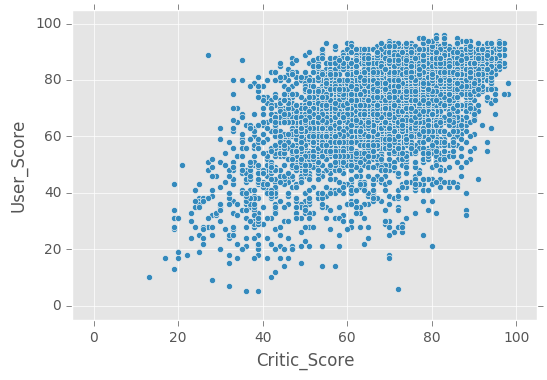

In [35]:
# Critic_Score and User_Score
short_dataset1.plot.scatter(x='Critic_Score', y='User_Score', xlim=(-5, 105), ylim=(-5,105))

In [36]:
"""
# Just for testing
if ('Platform_Manufacturer' in short_dataset1.keys()):
    groups = short_dataset1.groupby('Platform_Manufacturer')

    # Plot
    fig = plt.figure(figsize=(12,7))
    ax = fig.add_subplot(111)
    for name, group in groups:
        ax.plot(group.Critic_Score, group.User_Score, marker='.', linestyle='', label=name)
    ax.legend()
    plt.show()
    #fig.savefig('yourfilename.png')
"""    

"\n# Just for testing\nif ('Platform_Manufacturer' in short_dataset1.keys()):\n    groups = short_dataset1.groupby('Platform_Manufacturer')\n\n    # Plot\n    fig = plt.figure(figsize=(12,7))\n    ax = fig.add_subplot(111)\n    for name, group in groups:\n        ax.plot(group.Critic_Score, group.User_Score, marker='.', linestyle='', label=name)\n    ax.legend()\n    plt.show()\n    #fig.savefig('yourfilename.png')\n"

In [37]:
# convert nominal features to boolean features
short_dataset1 = convertNominalFeatures(short_dataset1, ['Platform', 'Genre', 'Rating', 'Platform_Manufacturer'])
short_dataset1 = dropNominalFeatures(short_dataset1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9c02b2dd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ff9b7903210>]], dtype=object)

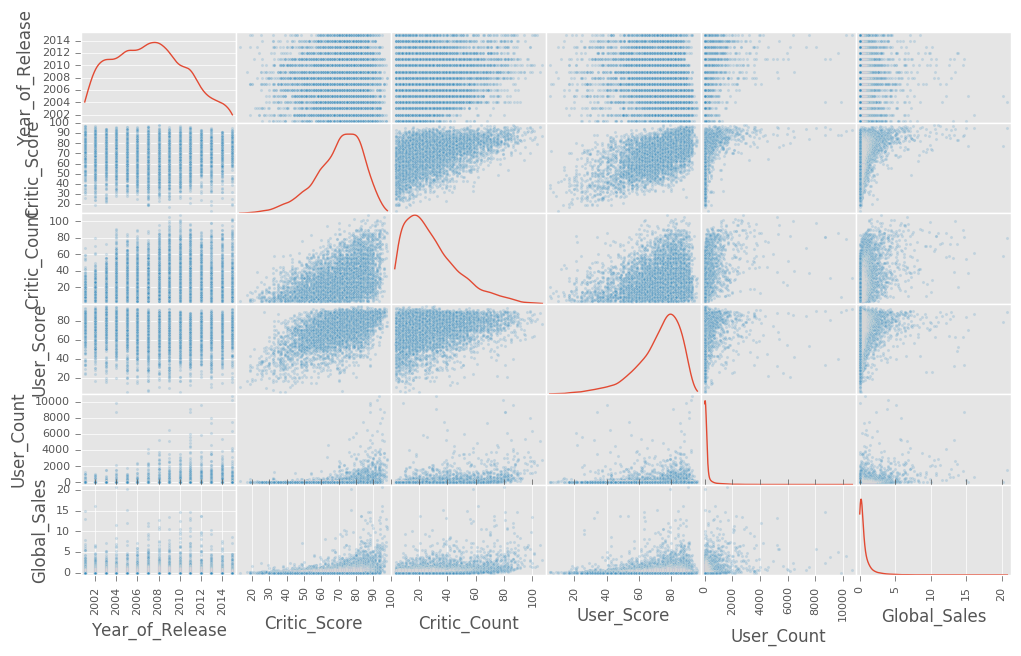

In [38]:
# show distributions
matrix_dataset1 = short_dataset1[['Year_of_Release', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Global_Sales']]
scatter_matrix(matrix_dataset1, alpha=0.2, figsize=(12, 7), diagonal='kde')

In [39]:
# test_set
# test_set1 = short_dataset1.copy()

# standardize features
short_dataset1, std_scaler = standardizeDataFrame(short_dataset1)

# scale features to range [0, 1]
# short_dataset1, minmax_scaler = scaleDataFrame(short_dataset1)

# run Box-Cox transformation => screws up, better r2, but only for transformed data
# short_dataset1, boxcox_lmbdas = boxcoxDataFrame(short_dataset1.copy())

In [40]:
# For each feature find the data points with extreme high or low values

display(short_dataset1.describe())
            
short_dataset1 = removeOutliers(short_dataset1.copy(), columns = ['Year_of_Release', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count','Global_Sales'], threshold = 1.5, multeity = 2)

display(short_dataset1.describe())

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,...,Rating_M,Rating_E,Rating_T,Rating_E10+,Rating_AO,Rating_RP,Platform_Manufacturer_Sony,Platform_Manufacturer_Nintendo,Platform_Manufacturer_Microsoft,Platform_Manufacturer_Sega
count,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000,...,6532.000000,6532.000000,6532.000000,6532.000000,6.532000e+03,6.532000e+03,6532.000000,6532.000000,6532.000000,6.532000e+03
mean,0.383944,0.016895,0.009213,0.002148,0.002973,0.014936,1.643464,0.157035,4.185480,0.004338,...,0.031177,0.075479,0.105874,0.013579,1.624550e-08,1.624550e-08,0.154588,0.056959,0.093784,2.599280e-07
std,0.208508,0.013396,0.009005,0.003938,0.002847,0.011940,0.626503,0.081558,1.775333,0.005222,...,0.060832,0.113957,0.145231,0.033712,1.312974e-06,1.312974e-06,0.190974,0.093253,0.133114,1.050138e-05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
25%,0.199981,0.005768,0.002091,0.000000,0.000900,0.004841,1.203012,0.096790,2.924979,0.000644,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
50%,0.376662,0.013030,0.005817,0.000000,0.001712,0.011394,1.658292,0.155759,4.281346,0.001945,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
75%,0.535718,0.026387,0.015131,0.001738,0.004743,0.023294,2.090888,0.220200,5.494942,0.006083,...,0.000000,0.247503,0.305060,0.000000,0.000000e+00,0.000000e+00,0.390476,0.209608,0.282694,0.000000e+00
max,0.771310,0.045590,0.028683,0.012205,0.009404,0.040621,3.320095,0.350503,8.743284,0.017483,...,0.149851,0.247503,0.305060,0.097259,1.061156e-04,1.061156e-04,0.390476,0.209608,0.282694,4.244625e-04


,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,...,Rating_M,Rating_E,Rating_T,Rating_E10+,Rating_AO,Rating_RP,Platform_Manufacturer_Sony,Platform_Manufacturer_Nintendo,Platform_Manufacturer_Microsoft,Platform_Manufacturer_Sega
count,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000,6532.000000,...,6532.000000,6532.000000,6532.000000,6532.000000,6.532000e+03,6.532000e+03,6532.000000,6532.000000,6532.000000,6.532000e+03
mean,0.383944,0.016895,0.009213,0.002148,0.002973,0.014936,1.643464,0.157035,4.185480,0.004338,...,0.031177,0.075479,0.105874,0.013579,1.624550e-08,1.624550e-08,0.154588,0.056959,0.093784,2.599280e-07
std,0.208508,0.013396,0.009005,0.003938,0.002847,0.011940,0.626503,0.081558,1.775333,0.005222,...,0.060832,0.113957,0.145231,0.033712,1.312974e-06,1.312974e-06,0.190974,0.093253,0.133114,1.050138e-05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
25%,0.199981,0.005768,0.002091,0.000000,0.000900,0.004841,1.203012,0.096790,2.924979,0.000644,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
50%,0.376662,0.013030,0.005817,0.000000,0.001712,0.011394,1.658292,0.155759,4.281346,0.001945,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
75%,0.535718,0.026387,0.015131,0.001738,0.004743,0.023294,2.090888,0.220200,5.494942,0.006083,...,0.000000,0.247503,0.305060,0.000000,0.000000e+00,0.000000e+00,0.390476,0.209608,0.282694,0.000000e+00
max,0.771310,0.045590,0.028683,0.012205,0.009404,0.040621,3.320095,0.350503,8.743284,0.017483,...,0.149851,0.247503,0.305060,0.097259,1.061156e-04,1.061156e-04,0.390476,0.209608,0.282694,4.244625e-04


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9b4f5e350>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ff9affe56d0>]], dtype=object)

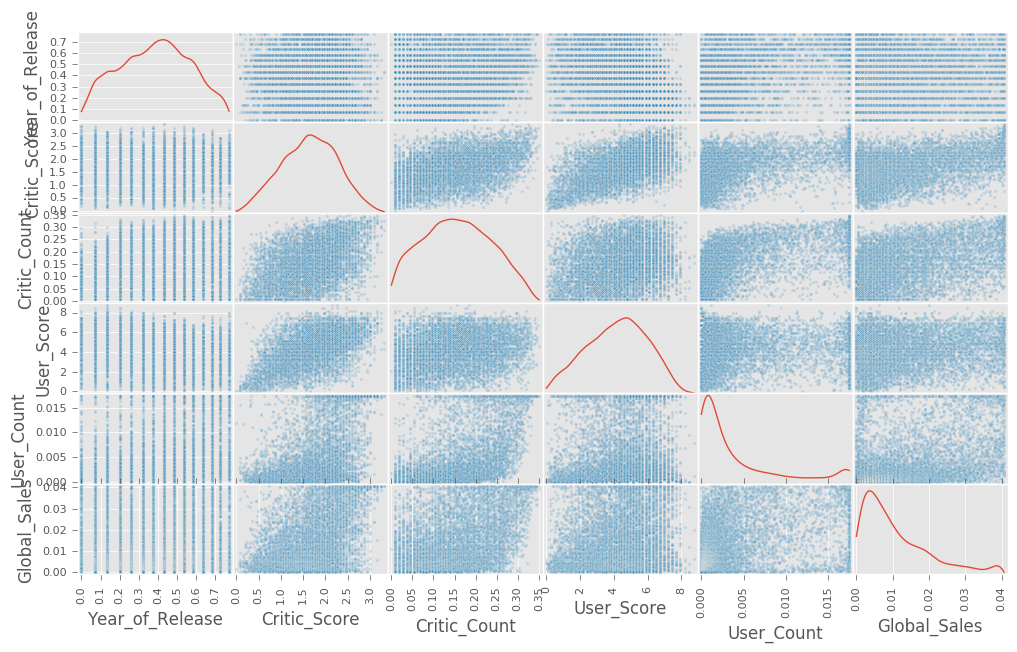

In [41]:
# show distributions
matrix_dataset1 = short_dataset1[['Year_of_Release', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Global_Sales']]
scatter_matrix(matrix_dataset1, alpha=0.2, figsize=(12, 7), diagonal='kde')

In [42]:
# split data into training set and test set
# separate features from target values
features, sales = separateTargetValues(short_dataset1)
#test_features, test_sales = separateTargetValues(test_set1)

# get five best predictors: Year, Scores, PC and Microsoft
#showKBest(features, sales['Global'])
    
# shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, sales['Global'], test_size=0.2, random_state=31415)

# Success
print "Training and testing split was successful."

Training and testing split was successful.


time.struct_time(tm_year=2017, tm_mon=2, tm_mday=18, tm_hour=21, tm_min=25, tm_sec=25, tm_wday=5, tm_yday=49, tm_isdst=0)

Regressor: Ridge(alpha=0.08, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.486
R² gap: 0.009
()


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


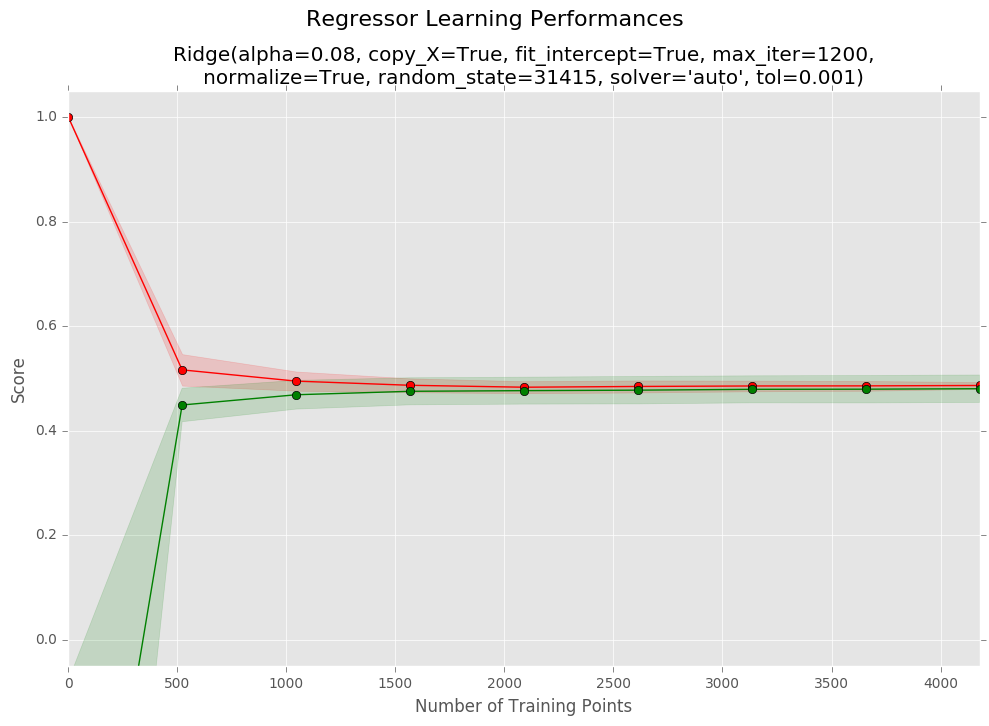

In [43]:
regressors = [0, 1, 2, 3, 4, 5]
reg_params = [0, 1, 2, 3, 4, 5]

random_state = 31415
n_splits = 20
test_size = 0.2

# create a RidgeRegression regressor object (best: 0.3096)
regressor = Ridge(random_state = random_state)
params = {'alpha': [0.08, 0.09, 0.1],    # positve float
          'fit_intercept': [True, False], # boolean
          'max_iter': [1200],             # integer
          'normalize': [True, False],     # boolean
          'solver': ['auto'] # {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag'}
         }
regressors[0] = regressor
reg_params[0] = params

# create a support vector regressor object
regressor = svm.SVR()
params = {'C': [0.7],
          'kernel': ['rbf'],
          'epsilon': [0.27, 0.3, 0.33],
          'gamma': ['auto']
         }       
regressors[1] = regressor
reg_params[1] = params

# create a decision tree regressor object
regressor = DecisionTreeRegressor(random_state = random_state)
params = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}
regressors[2] = regressor
reg_params[2] = params

# create a LarsLasso regressor object
regressor = LassoLars()
params = {'alpha': [0.03, 0.07, 0.1, 0.13],
          'fit_intercept': [True, False],
          'positive': [True, False],
          'normalize': [True, False],
          'max_iter': [1200, 1500]
         }
regressors[3] = regressor
reg_params[3] = params

# create a ElasticNet regressor object
regressor = ElasticNet()
params = {'alpha': [0.07, 0.1],
          'l1_ratio': [0, 0.1, 0.2, 0.3],
          'fit_intercept': [True, False],
          'normalize': [True, False],
          'max_iter' : [1200]
         }
regressors[4] = regressor
reg_params[4] = params

# create a Neural Network regressor object
regressor = MLPRegressor(random_state = random_state)
params = {'hidden_layer_sizes': [(150,), (200,), (250,)],
          'alpha': [0.00093, 0.00097, 0.0001, 0.00013],
          'solver': ['lbfgs', 'sgd', 'adam']
         }
regressors[5] = regressor
reg_params[5] = params

total_start_time = time.time()
display(time.localtime(total_start_time))

results_columns = ['Regressor', 'R2_Train', 'R2_Test', 'R2_Gap', 'Calc_Time', 'Standardized', 'Scaled_0_1', 'Boxcoxed', 'Outlier_Threshold', 'Outlier_Multiety', 'Test_Size', 'N_Splits', 'RND']
results = pd.DataFrame(columns = results_columns)

for index in range(1):
#for index in range(len(regressors)):
    start_time = time.time()
    # Fit the training data to the model using grid search
    reg, reg_score_train, reg_score_test, reg_gap = getScores(X_train, y_train, X_test, y_test, regressors[index], reg_params[index], n_splits, test_size, random_state)
    end_time = time.time()
    
    print('Regressor: {}'.format(reg))
    print('R² score (train): {:.3f}'.format(reg_score_train))
    print('R² gap: {:.3f}'.format(reg_gap))
    print()
    
    displayLearningCurve(X_train, y_train, reg, n_splits, test_size, random_state, params)

In [62]:
#STANDARDIZE_SET   = False
#SCALE_SET_0_1     = False
#BOXCOX_SET        = False
#OUTLIER_THRESHOLD = 1.5
#OUTLIER_MULTIETY  = 2
#N_SPLITS          = 20
#TEST_SIZE         = 0.2
#RANDOM_STATE      = 31415

params_standardize_set = [False, True]
params_scale_set_0_1   = [False, True]
params_boxcox_set      = [False]
params_outlier_threshold = [1.5, 2]
params_outlier_multiety = [1, 2, 3]
params_n_splits = [10, 15]
params_test_size = [0.2]
params_random_state = [31415]

combinations = len(params_standardize_set) * len(params_scale_set_0_1) * len(params_boxcox_set) * len(params_outlier_threshold) * len(params_outlier_multiety) * len(params_n_splits) * len(params_test_size) * len(params_random_state)

results_columns = ['Id', 'Regressor', 'R2_Train', 'R2_Test', 'R2_Gap', 'Calc_Time', 'Standardized', 'Scaled_0_1', 'Boxcoxed', 'Outlier_Threshold', 'Outlier_Multiety', 'Test_Size', 'N_Splits', 'RND']
results = pd.DataFrame(columns = results_columns)

rid = 1
best_r2 = (0, -1)
best_gap = (0, -1)

for standardize_set in params_standardize_set:
    for scale_set_0_1 in params_scale_set_0_1:
        for boxcox_set in params_boxcox_set:
            for outlier_threshold in params_outlier_threshold:
                for outlier_multiety in params_outlier_multiety:
                    for n_splits in params_n_splits:
                        for test_size in params_test_size:
                            for random_state in params_random_state:
                                X_train, y_train, X_test, y_test = prepare_sets(standardize_set, scale_set_0_1, boxcox_set, outlier_threshold, outlier_multiety, n_splits, test_size, random_state)
                               
                                regressors = [0, 1, 2, 3, 4, 5]
                                reg_params = [0, 1, 2, 3, 4, 5]

                                # create a RidgeRegression regressor object (best: 0.3096)
                                regressor = Ridge(random_state = random_state)
                                params = {'alpha': [0.07, 0.1, 1.3],    # positve float
                                          'fit_intercept': [True, False], # boolean
                                          'max_iter': [1200],             # integer
                                          'normalize': [True, False],     # boolean
                                          'solver': ['auto'] # {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag'}
                                         }
                                regressors[0] = regressor
                                reg_params[0] = params

                                # create a support vector regressor object
                                regressor = svm.SVR()
                                params = {'C': [0.7],
                                          'kernel': ['rbf'],
                                          'epsilon': [0.1, 0.3, 0.7],
                                          'gamma': ['auto']
                                         }       
                                regressors[1] = regressor
                                reg_params[1] = params

                                # create a decision tree regressor object
                                regressor = DecisionTreeRegressor(random_state = random_state)
                                params = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}
                                regressors[2] = regressor
                                reg_params[2] = params

                                # create a LarsLasso regressor object
                                regressor = LassoLars()
                                params = {'alpha': [0.03, 0.07, 0.1, 0.13],
                                          'fit_intercept': [True, False],
                                          'positive': [True, False],
                                          'normalize': [True, False],
                                          'max_iter': [1200, 1500]
                                         }
                                regressors[3] = regressor
                                reg_params[3] = params

                                # create a ElasticNet regressor object
                                regressor = ElasticNet()
                                params = {'alpha': [0.07, 0.1],
                                          'l1_ratio': [0, 0.1, 0.2, 0.3],
                                          'fit_intercept': [True, False],
                                          'normalize': [True, False],
                                          'max_iter' : [1200]
                                         }
                                regressors[4] = regressor
                                reg_params[4] = params

                                # create a Neural Network regressor object
                                regressor = MLPRegressor(random_state = random_state)
                                params = {'hidden_layer_sizes': [(150,), (200,), (250,)],
                                          'alpha': [0.00093, 0.00097, 0.0001, 0.00013],
                                          'solver': ['lbfgs', 'sgd', 'adam']
                                         }
                                regressors[5] = regressor
                                reg_params[5] = params

                                total_start_time = time.time()
                                display(time.localtime(total_start_time))

                                for index in range(5):
                                #for index in range(len(regressors)):
                                    start_time = time.time()
                                    # Fit the training data to the model using grid search
                                    reg, reg_score_train, reg_score_test, reg_gap = getScores(X_train, y_train, X_test, y_test, regressors[index], reg_params[index], n_splits, test_size, random_state)
                                    end_time = time.time()
                                    
                                    print('ID: {} (of {})'.format(rid, combinations * len(regressors)))
                                    print('standardize_set={}, scale_set_0_1={}, boxcox_set={}'.format(standardize_set, scale_set_0_1, boxcox_set))
                                    print('outlier_threshold={}, outlier_multiety={}'.format(outlier_threshold, outlier_multiety))
                                    print('n_splits={}, test_size={}, random_state={}'.format(n_splits, test_size, random_state))
                                    print('X_train.shape={}'.format(X_train.shape))
                                    print('Regressor: {}'.format(reg))
                                    print('R² score (train): {:.3f}'.format(reg_score_train))
                                    print('R² gap: {:.3f}'.format(reg_gap))
                                    print('==============================')

                                    if ((reg_score_train > best_r2[0]) | (best_r2[1] < 0)):
                                        best_r2 = (reg_score_train, rid)
                                    if ((reg_gap < best_gap[0]) | (best_gap[1] < 0)):
                                        best_gap = (reg_gap, rid)
                                        
                                    print('best r2: {} / best gap: {}'.format(best_r2, best_gap))
                                    print('==============================')
                                    
                                    #displayLearningCurve(X_train, y_train, reg, n_splits, test_size, random_state, params)

                                    result = pd.DataFrame(
                                        [[
                                                rid,
                                                reg,
                                                reg_score_train,
                                                reg_score_test,
                                                reg_gap,
                                                end_time - start_time,
                                                standardize_set,
                                                scale_set_0_1,
                                                boxcox_set,
                                                outlier_threshold,
                                                outlier_multiety,
                                                test_size,
                                                n_splits,
                                                random_state
                                            ]],
                                        columns = results_columns)
                                    results = results.append(result)
                                    rid = rid + 1
 
display(results)
print('BEST R²')
display(results.nlargest(1, 'R2_Train').head())
print('BEST GAP')
display(results.nsmallest(1, 'R2_Gap').head())

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=18, tm_hour=21, tm_min=59, tm_sec=46, tm_wday=5, tm_yday=49, tm_isdst=0)

ID: 1 (of 48)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=10, test_size=0.2, random_state=31415
X_train.shape=(4991, 45)
Regressor: Ridge(alpha=1.3, copy_X=True, fit_intercept=False, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.278
R² gap: 0.181
best r2: (0.27774853810955225, 1) / best gap: (0.18079124092760968, 1)
ID: 2 (of 48)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=10, test_size=0.2, random_state=31415
X_train.shape=(4991, 45)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.751
R² gap: 0.397
best r2: (0.75089235523707898, 2) / best gap: (0.18079124092760968, 1)
ID: 3 (of 48)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ID: 5 (of 48)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=10, test_size=0.2, random_state=31415
X_train.shape=(4991, 45)
Regressor: ElasticNet(alpha=0.07, copy_X=True, fit_intercept=True, l1_ratio=0,
      max_iter=1200, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
R² score (train): 0.249
R² gap: 0.322
best r2: (0.75089235523707898, 2) / best gap: (0.18079124092760968, 1)
ID: 6 (of 48)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=10, test_size=0.2, random_state=31415
X_train.shape=(4991, 45)
Regressor: MLPRegressor(activation='relu', alpha=0.00013, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_mo

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=18, tm_hour=22, tm_min=12, tm_sec=48, tm_wday=5, tm_yday=49, tm_isdst=0)

ID: 7 (of 48)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=15, test_size=0.2, random_state=31415
X_train.shape=(4986, 45)
Regressor: Ridge(alpha=1.3, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=False, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.278
R² gap: 0.224
best r2: (0.75089235523707898, 2) / best gap: (0.18079124092760968, 1)
ID: 8 (of 48)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=1
n_splits=15, test_size=0.2, random_state=31415
X_train.shape=(4986, 45)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.751
R² gap: 0.409
best r2: (0.7510925045203789, 8) / best gap: (0.18079124092760968, 1)
ID: 9 (of 48)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_

time.struct_time(tm_year=2017, tm_mon=2, tm_mday=18, tm_hour=22, tm_min=31, tm_sec=13, tm_wday=5, tm_yday=49, tm_isdst=0)

ID: 13 (of 48)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=2
n_splits=10, test_size=0.2, random_state=31415
X_train.shape=(6093, 45)
Regressor: Ridge(alpha=0.07, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=31415, solver='auto', tol=0.001)
R² score (train): 0.183
R² gap: 0.370
best r2: (0.7510925045203789, 8) / best gap: (0.18079124092760968, 1)
ID: 14 (of 48)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlier_multiety=2
n_splits=10, test_size=0.2, random_state=31415
X_train.shape=(6093, 45)
Regressor: SVR(C=0.7, cache_size=200, coef0=0.0, degree=3, epsilon=0.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
R² score (train): 0.385
R² gap: 0.201
best r2: (0.7510925045203789, 8) / best gap: (0.18079124092760968, 1)
ID: 15 (of 48)
standardize_set=False, scale_set_0_1=False, boxcox_set=False
outlier_threshold=1.5, outlie

/usr/local/lib/python2.7/dist-packages/sklearn/neural_network/_base.py:194: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/usr/local/lib/python2.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').